In [1]:
import tensorflow as tf
import numpy as np

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
class BatchContainerLight(object):
    
    def __init__(self, X, y,  batch_size):
        self.batch_size = batch_size
        self.X = X
        self.y = y        
        
    def __iter__(self):
        return self._iterator()
        
    def _iterator(self):
        for i in range(self._number_batches()):
            start = i * self.batch_size
            end = (i+1) * self.batch_size
            if self.y is not None:
                yield self.X[start:end, :], self.y[start:end, :]
            else:
                yield self.X[start:end, :]  

    def _number_batches(self):
        n, _ = self.X.shape
        return int(np.ceil(n/self.batch_size))

In [4]:
from sklearn.base import BaseEstimator

class NNModel():
    def __init__(self, learning_rate=0.1, batch_size=128, n_epochs=200, activation=tf.nn.relu, l2_reg=0.01):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.activation = activation
        self.l2_reg = l2_reg
        

    def fit(self, X, y):
                
        self._computational_graph(X, y)
               
        batch_container = BatchContainerLight(X, y, self.batch_size)

        
        for epoch in range(self.n_epochs):
            for X_batch, y_batch in batch_container:
                self.session.run(self.training_op, feed_dict={self.X: X_batch, self.y: y_batch})
            if epoch % 50 == 0:
                mse = self.session.run(self.loss, feed_dict={self.X: X_batch, self.y: y_batch})
                print(epoch, "\tMSE:", mse)
        
        return self
    
    def predict(self, X):
           
        return self.session.run(self.outputs, feed_dict={self.X: X})
    
    def score(self, X, y):
        pred = self.predict(X)
        return np.mean( (pred-y)**2)
    
    def get_params(self, deep=True):
        return {'learning_rate': self.learning_rate,
                'batch_size': self.batch_size,
                'n_epochs': self.n_epochs,
                'activation': self.activation,
                'l2_reg': self.l2_reg}
    
    def set_params(self, learning_rate=None, batch_size=None, n_epochs=None, activation=None, l2_reg=None):
        if learning_rate!=None:
            self.learning_rate = learning_rate
        if batch_size!=None:
            self.batch_size = batch_size
        if n_epochs!=None:
            self.n_epochs = n_epochs
        if activation!=None:
            self.activation = activation
        if l2_reg!=None:
            self.l2_reg = l2_reg
        return self
           
    def _computational_graph(self, X, y):
        
        _, n_inputs = X.shape
        _, n_outputs = y.shape


        tf.reset_default_graph()
        
        self.X = tf.placeholder(tf.float32, [None, n_inputs])
        self.y = tf.placeholder(tf.float32, [None,  n_outputs])

        regularizer = tf.contrib.layers.l2_regularizer(scale=self.l2_reg)
        
        layer_1 = tf.layers.dense(self.X, 125, activation=self.activation, kernel_regularizer=regularizer, name='layer_1')
        layer_2 = tf.layers.dense(layer_1, 50, activation=self.activation, kernel_regularizer=regularizer, name='layer_2')
        layer_3 = tf.layers.dense(layer_2, 25, activation=self.activation, kernel_regularizer=regularizer, name='layer_3')
        self.outputs = tf.layers.dense(layer_3, n_outputs, activation=None, name='outputs')
        
        l2_loss = tf.losses.get_regularization_loss()
        self.loss = tf.reduce_mean(tf.square(self.outputs-self.y)) + l2_loss
        
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.training_op = optimizer.minimize(self.loss)

        self.init = tf.global_variables_initializer()
        self.session = tf.Session()
        self.session.run(self.init)

In [5]:
x = np.linspace(0, 1, 50)
y = 3*x*x*x+5

X = x.reshape(-1,1)
y = y.reshape(-1,1)

model = NNModel(learning_rate=0.1, batch_size=128, n_epochs=400)

model.fit(X, y)

0 	MSE: 6.13656
50 	MSE: 1.49387
100 	MSE: 0.818143
150 	MSE: 0.570004
200 	MSE: 0.400948
250 	MSE: 0.293531
300 	MSE: 0.226772
350 	MSE: 0.183279


In [6]:
x_test = np.linspace(-0.5, 1.5, 100)
y_test = 3*x_test*x_test*x_test+5

In [7]:
pred = model.predict(x.reshape(-1,1))

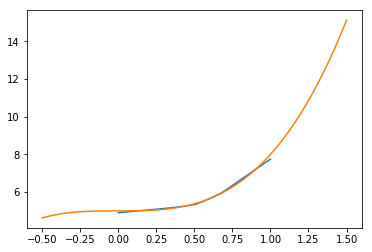

In [8]:
plt.plot(x, pred)
plt.plot(x_test, y_test)

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
mse = make_scorer(mean_squared_error, greater_is_better=False)
parameters = {'learning_rate':[0.1, 0.05, 0.01], 'activation':[tf.nn.relu, tf.nn.tanh], 'n_epochs': [250, 500, 1000, 1500]}

gs = GridSearchCV(NNModel(), parameters, cv=2, scoring=mse)
gs.fit(X, y)

0 	MSE: 24.0876
50 	MSE: 1.45208
100 	MSE: 0.51705
150 	MSE: 0.289748
200 	MSE: 0.194966
0 	MSE: 3.5097
50 	MSE: 1.07717
100 	MSE: 0.602672
150 	MSE: 0.431084
200 	MSE: 0.319222
0 	MSE: 2.83923
50 	MSE: 2.16709
100 	MSE: 1.29762
150 	MSE: 0.930851
200 	MSE: 0.730649
250 	MSE: 0.607629
300 	MSE: 0.523444
350 	MSE: 0.460114
400 	MSE: 0.409126
450 	MSE: 0.366326
0 	MSE: 5.01172
50 	MSE: 1.3358
100 	MSE: 0.709489
150 	MSE: 0.476984
200 	MSE: 0.337698
250 	MSE: 0.246444
300 	MSE: 0.184514
350 	MSE: 0.141331
400 	MSE: 0.110408
450 	MSE: 0.0877169
0 	MSE: 32.1067
50 	MSE: 0.579835
100 	MSE: 0.180545
150 	MSE: 0.112439
200 	MSE: 0.0856513
250 	MSE: 0.0703189
300 	MSE: 0.0610105
350 	MSE: 0.0549989
400 	MSE: 0.0507802
450 	MSE: 0.253912
500 	MSE: 0.0523142
550 	MSE: 0.0483618
600 	MSE: 0.04609
650 	MSE: 0.0442609
700 	MSE: 0.0427038
750 	MSE: 0.0413226
800 	MSE: 0.040085
850 	MSE: 0.0389508
900 	MSE: 0.0447303
950 	MSE: 0.0378369
0 	MSE: 1.56552
50 	MSE: 0.836089
100 	MSE: 0.349988
150 	MSE: 0.

250 	MSE: 0.682061
300 	MSE: 0.881965
350 	MSE: 0.702595
400 	MSE: 0.780035
450 	MSE: 0.778993
500 	MSE: 0.698511
550 	MSE: 0.622119
600 	MSE: 3.60287
650 	MSE: 8.23773
700 	MSE: 2.05446
750 	MSE: 1.00836
800 	MSE: 0.742665
850 	MSE: 0.653457
900 	MSE: 0.631956
950 	MSE: 0.620887
0 	MSE: 2.08242
50 	MSE: 0.313856
100 	MSE: 0.0404105
150 	MSE: 0.0441198
200 	MSE: 0.198126
250 	MSE: 0.0532837
300 	MSE: 0.0322129
350 	MSE: 0.0226013
400 	MSE: 0.0195784
450 	MSE: 0.0174806
500 	MSE: 0.0273112
550 	MSE: 0.0182877
600 	MSE: 1.05464
650 	MSE: 33.0466
700 	MSE: 28.6509
750 	MSE: 14.013
800 	MSE: 10.5257
850 	MSE: 5.38508
900 	MSE: 3.34227
950 	MSE: 2.22833
0 	MSE: 3.13646
50 	MSE: 4.15936
100 	MSE: 2.54036
150 	MSE: 1.73955
200 	MSE: 0.771722
250 	MSE: 0.661463
300 	MSE: 0.670262
350 	MSE: 0.738054
400 	MSE: 1.32674
450 	MSE: 0.633662
500 	MSE: 0.64747
550 	MSE: 0.632787
600 	MSE: 1.14109
650 	MSE: 0.687825
700 	MSE: 0.672281
750 	MSE: 0.660622
800 	MSE: 0.619484
850 	MSE: 0.618871
900 	MSE: 0

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=<__main__.NNModel object at 0x7fd619a925c0>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.1, 0.05, 0.01], 'activation': [<function relu at 0x7fd64c38b7b8>, <function tanh at 0x7fd64c274840>], 'n_epochs': [250, 500, 1000, 1500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [10]:
gs.cv_results_

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([ 0.73039782,  1.07990539,  1.63291574,  2.30943906,  0.80185938,
         1.14455235,  1.76275623,  2.34843159,  0.96644688,  1.51771069,
         1.6589005 ,  2.24972129,  0.66709554,  0.94695032,  1.39211428,
         1.99630415,  0.73581338,  1.01109362,  1.44122183,  1.95377362,
         0.70143044,  0.98322666,  1.39276338,  1.89491081]),
 'std_fit_time': array([  3.83007526e-03,   7.34366179e-02,   2.13534832e-02,
          3.15274000e-02,   2.40714550e-02,   1.39092207e-02,
          1.86401606e-02,   3.38039398e-02,   2.82871723e-02,
          3.98104191e-01,   3.54750156e-02,   8.10158253e-02,
          3.59976292e-03,   5.71719408e-02,   4.81498241e-03,
          1.45117044e-02,   2.35533714e-03,   7.78062344e-02,
          3.70475054e-02,   1.90674067e-02,   1.23381615e-04,
          5.62924147e-02,   1.48632526e-02,   3.85224819e-02]),
 'mean_score_time': array([ 0.02673173,  0.02643967,  0.03208756,  0.02950788,  0.03354323,
         0.03023171,  0

In [11]:
gs.best_estimator_.get_params()

{'learning_rate': 0.05,
 'batch_size': 128,
 'n_epochs': 1500,
 'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>,
 'l2_reg': 0.01}